# ETL Processes
Use this notebook to develop the ETL process for each of your tables before completing the `etl.py` file to load the whole datasets.

In [132]:
import os
import glob
import psycopg2
from sql_queries import *
import numpy as np
# import libraries for graphics
import pandas as pd
import plotly as px
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
from scipy import stats
from pyspark.sql.functions import udf
import warnings
warnings.filterwarnings("ignore")

In [152]:
# Setting color palette
colors=['#FDE724','#D01C8B','#4DAC26']
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [3]:
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files

# Process `song_data`
In this first part, you'll perform ETL on the first dataset, `song_data`, to create the `songs` and `artists` dimensional tables.

Let's perform ETL on a single song file and load a single record into each table to start.
- Use the `get_files` function provided above to get a list of all song JSON files in `data/song_data`
- Select the first song in this list
- Read the song file and view the data

In [4]:
filepath_song_data = "./data/song_data"

In [5]:
song_files = get_files(filepath_song_data)

In [6]:
filepath = song_files[0]

In [7]:
filepath

'/home/workspace/data/song_data/A/A/A/TRAAAAW128F429D538.json'

In [8]:
df = pd.read_json(filepath,orient='records',lines=True)
df.head()

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
0,ARD7TVE1187B99BFB1,NaN,California - LA,NaN,Casual,218.93179,1,SOMZWCG12A8C13C480,I Didn't Mean To,0


## #1: `songs` Table
#### Extract Data for Songs Table
- Select columns for song ID, title, artist ID, year, and duration
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `song_data`

In [9]:
song_columns = ['song_id','title','artist_id','year','duration']
song_data = df[song_columns].values[0].tolist()
song_data

['SOMZWCG12A8C13C480', "I Didn't Mean To", 'ARD7TVE1187B99BFB1', 0, 218.93179]

#### Insert Record into Song Table
Implement the `song_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song into the `songs` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songs` table in the sparkify database.

In [10]:
cur.execute(song_table_insert, song_data)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

## #2: `artists` Table
#### Extract Data for Artists Table
- Select columns for artist ID, name, location, latitude, and longitude
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `artist_data`

In [11]:
df

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
0,ARD7TVE1187B99BFB1,NaN,California - LA,NaN,Casual,218.93179,1,SOMZWCG12A8C13C480,I Didn't Mean To,0


In [12]:
artist_columns = ['artist_id','artist_name','artist_location','artist_latitude','artist_longitude']
artist_data = df[artist_columns].values[0].tolist()
artist_data

['ARD7TVE1187B99BFB1', 'Casual', 'California - LA', nan, nan]

#### Insert Record into Artist Table
Implement the `artist_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song's artist into the `artists` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `artists` table in the sparkify database.

In [13]:
cur.execute(artist_table_insert, artist_data)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

# Process `log_data`
In this part, you'll perform ETL on the second dataset, `log_data`, to create the `time` and `users` dimensional tables, as well as the `songplays` fact table.

Let's perform ETL on a single log file and load a single record into each table.
- Use the `get_files` function provided above to get a list of all log JSON files in `data/log_data`
- Select the first log file in this list
- Read the log file and view the data

In [14]:
filepath_log_data = "./data/log_data"
log_files = get_files(filepath_log_data)

In [15]:
filepath = log_files[0]

In [16]:
df = pd.read_json(filepath,orient='records',lines=True)
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Stephen Lynch,Logged In,Jayden,M,0,Bell,182.85669,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1.540992e+12,829,Jim Henson's Dead,200,1543537327796,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,91
1,Manowar,Logged In,Jacob,M,0,Klein,247.56200,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Shell Shock,200,1543540121796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
2,Morcheeba,Logged In,Jacob,M,1,Klein,257.41016,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Women Lose Weight (Feat: Slick Rick),200,1543540368796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
3,Maroon 5,Logged In,Jacob,M,2,Klein,231.23546,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Won't Go Home Without You,200,1543540625796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
4,Train,Logged In,Jacob,M,3,Klein,216.76363,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Hey_ Soul Sister,200,1543540856796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73


## #3: `time` Table
#### Extract Data for Time Table
- Filter records by `NextSong` action
- Convert the `ts` timestamp column to datetime
  - Hint: the current timestamp is in milliseconds
- Extract the timestamp, hour, day, week of year, month, year, and weekday from the `ts` column and set `time_data` to a list containing these values in order
  - Hint: use pandas' [`dt` attribute](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to access easily datetimelike properties.
- Specify labels for these columns and set to `column_labels`
- Create a dataframe, `time_df,` containing the time data for this file by combining `column_labels` and `time_data` into a dictionary and converting this into a dataframe

In [17]:
df = df[df['page']=='NextSong']
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Stephen Lynch,Logged In,Jayden,M,0,Bell,182.85669,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1.540992e+12,829,Jim Henson's Dead,200,1543537327796,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,91
1,Manowar,Logged In,Jacob,M,0,Klein,247.56200,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Shell Shock,200,1543540121796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
2,Morcheeba,Logged In,Jacob,M,1,Klein,257.41016,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Women Lose Weight (Feat: Slick Rick),200,1543540368796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
3,Maroon 5,Logged In,Jacob,M,2,Klein,231.23546,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Won't Go Home Without You,200,1543540625796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73
4,Train,Logged In,Jacob,M,3,Klein,216.76363,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Hey_ Soul Sister,200,1543540856796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73


In [18]:
t = pd.to_datetime(df['ts'],unit='ms')
t.head()

0   2018-11-30 00:22:07.796
1   2018-11-30 01:08:41.796
2   2018-11-30 01:12:48.796
3   2018-11-30 01:17:05.796
4   2018-11-30 01:20:56.796
Name: ts, dtype: datetime64[ns]

In [19]:
df['ts'] = pd.to_datetime(df['ts'],unit='ms')
df['ts'].head()

0   2018-11-30 00:22:07.796
1   2018-11-30 01:08:41.796
2   2018-11-30 01:12:48.796
3   2018-11-30 01:17:05.796
4   2018-11-30 01:20:56.796
Name: ts, dtype: datetime64[ns]

In [20]:
# Extract the timestamp, hour, day, week of year, month, year, and weekday from the ts column and set time_data to a list containing these values in order
# Hint: use pandas' dt attribute to access easily datetimelike properties.
# Specify labels for these columns and set to column_labels
# Create a dataframe, time_df, containing the time data for this file by combining column_labels and time_data into a dictionary and converting this into a dataframe

In [21]:
time_data = list((t,t.dt.hour,t.dt.day,t.dt.weekofyear, t.dt.month, t.dt.year, t.dt.weekday))
column_labels = list(('play_time','hour','day','week','month','year','weekday'))

In [22]:
time_df = pd.DataFrame(dict(zip(column_labels, time_data)))
time_df.head()

,play_time,hour,day,week,month,year,weekday
0,2018-11-30 00:22:07.796,0,30,48,11,2018,4
1,2018-11-30 01:08:41.796,1,30,48,11,2018,4
2,2018-11-30 01:12:48.796,1,30,48,11,2018,4
3,2018-11-30 01:17:05.796,1,30,48,11,2018,4
4,2018-11-30 01:20:56.796,1,30,48,11,2018,4


#### Insert Records into Time Table
Implement the `time_table_insert` query in `sql_queries.py` and run the cell below to insert records for the timestamps in this log file into the `time` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `time` table in the sparkify database.

In [23]:
for i, row in time_df.iterrows():
    cur.execute(time_table_insert, list(row))
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

## #4: `users` Table
#### Extract Data for Users Table
- Select columns for user ID, first name, last name, gender and level and set to `user_df`

In [24]:
user_columns = ['userId','firstName','lastName','gender','level']
user_df = df[user_columns]
user_df.head(5)

,userId,firstName,lastName,gender,level
0,91,Jayden,Bell,M,free
1,73,Jacob,Klein,M,paid
2,73,Jacob,Klein,M,paid
3,73,Jacob,Klein,M,paid
4,73,Jacob,Klein,M,paid


In [25]:
# As there is several rows with null value on userId field, I got an error while loading the user data
# I have searched on the Knowledge site and there is a proposal to get rid of these rows with null values
# So I filter the dataframe to eliminate these null values on userId field
user_df=user_df[user_df['userId']!=""]

In [26]:
#for i, row in user_df.iterrows():
#    print (i, row)

#### Insert Records into Users Table
Implement the `user_table_insert` query in `sql_queries.py` and run the cell below to insert records for the users in this log file into the `users` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `users` table in the sparkify database.

In [27]:
for i, row in user_df.iterrows():
    cur.execute(user_table_insert, row)
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

## #5: `songplays` Table
#### Extract Data and Songplays Table
This one is a little more complicated since information from the songs table, artists table, and original log file are all needed for the `songplays` table. Since the log file does not specify an ID for either the song or the artist, you'll need to get the song ID and artist ID by querying the songs and artists tables to find matches based on song title, artist name, and song duration time.
- Implement the `song_select` query in `sql_queries.py` to find the song ID and artist ID based on the title, artist name, and duration of a song.
- Select the timestamp, user ID, level, song ID, artist ID, session ID, location, and user agent and set to `songplay_data`

#### Insert Records into Songplays Table
- Implement the `songplay_table_insert` query and run the cell below to insert records for the songplay actions in this log file into the `songplays` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songplays` table in the sparkify database.

In [28]:
for index, row in df.iterrows():

    # get songid and artistid from song and artist tables
    cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()  
    
    if results:
        songid, artistid = results
    else:
        songid, artistid = None, None

    # insert songplay record: these are the fields that need to have a record of songplay (9 fields)
    # songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent
 
    songplay_data = [index,row.ts,row.userId,row.level,songid,artistid,row.sessionId,row.location,row.userAgent]      
    cur.execute(songplay_table_insert, songplay_data)
    conn.commit()

## #6: EXPLORATORY DATA ANALYSIS
#### Let's explore data!!!

We start by importing the needed libraries to prepare nice plots!

In [29]:
# import libraries for graphics
import numpy as np
import matplotlib.pyplot as plt
import plotly as px
import seaborn as sns 
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Setting color palette
colors=['#FDE724','#D01C8B','#4DAC26']
pd.set_option('display.max_columns', 500)

In [31]:
# Let's see how the content of df is, visualizing only two records
df.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Stephen Lynch,Logged In,Jayden,M,0,Bell,182.85669,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1.540992e+12,829,Jim Henson's Dead,200,2018-11-30 00:22:07.796,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,91
1,Manowar,Logged In,Jacob,M,0,Klein,247.56200,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Shell Shock,200,2018-11-30 01:08:41.796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73


In [32]:
# Let's have an idea of the df dataset
df.describe()

,itemInSession,length,registration,sessionId,status
count,330.000000,330.000000,3.300000e+02,330.000000,330.0
mean,16.630303,251.803094,1.540887e+12,1050.260606,200.0
std,14.400998,76.354338,1.905504e+08,62.047280,0.0
min,0.000000,65.253420,1.540465e+12,618.000000,200.0
25%,5.000000,205.237100,1.540872e+12,1049.000000,200.0
50%,13.000000,240.495875,1.540941e+12,1076.000000,200.0
75%,25.000000,286.242813,1.541020e+12,1079.000000,200.0
max,60.000000,655.777510,1.541063e+12,1114.000000,200.0


In [117]:
# It's good to know the numerical types in our dataset
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')]

In [118]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,itemInSession,length,registration,sessionId,status
0,0,182.85669,1.540992e+12,829,200
1,0,247.56200,1.540558e+12,1049,200
2,1,257.41016,1.540558e+12,1049,200
3,2,231.23546,1.540558e+12,1049,200
4,3,216.76363,1.540558e+12,1049,200


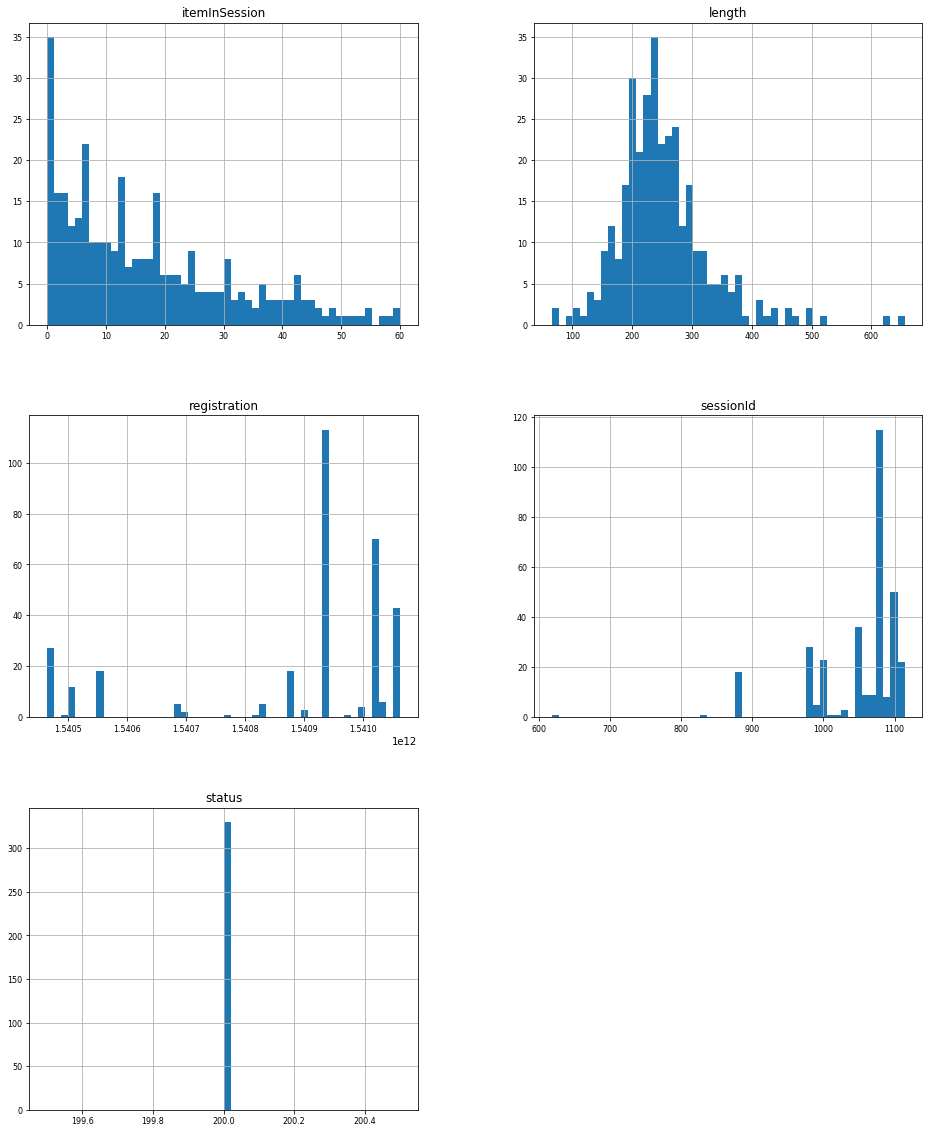

In [153]:
# Let's plot them
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

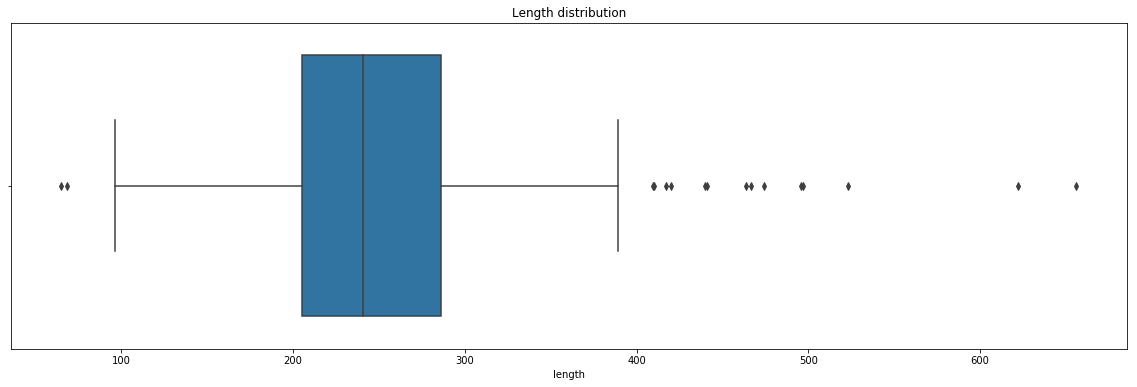

In [181]:
# Observing the length, we can guess that there are some outliers, are we sure?
sns.boxplot(x=df['length']).set_title('Length distribution');

count    330.000000
mean      16.630303
std       14.400998
min        0.000000
25%        5.000000
50%       13.000000
75%       25.000000
max       60.000000
Name: itemInSession, dtype: float64


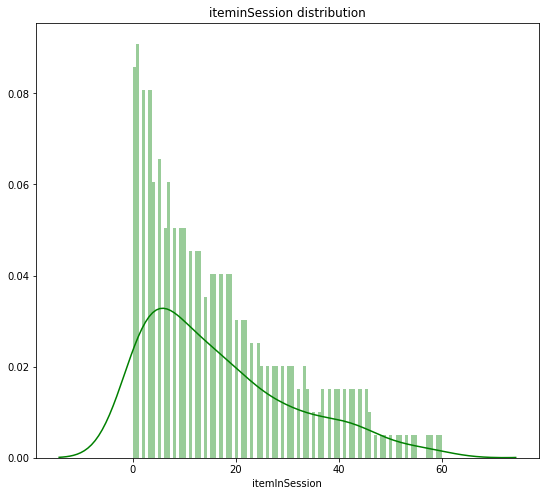

In [182]:
# Now let's see how the iteminSession is distributed
print(df['itemInSession'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['itemInSession'], color='g', bins=100, hist_kws={'alpha': 0.4}).set_title('iteminSession distribution');

In [156]:
# Let's check iteminSession
# Histogram gives us information about Kurtosis and skewness.
# Normal Probability Plot wiith that plot, we can check if Data distribution follows the diagonal that represents the normal distribution.

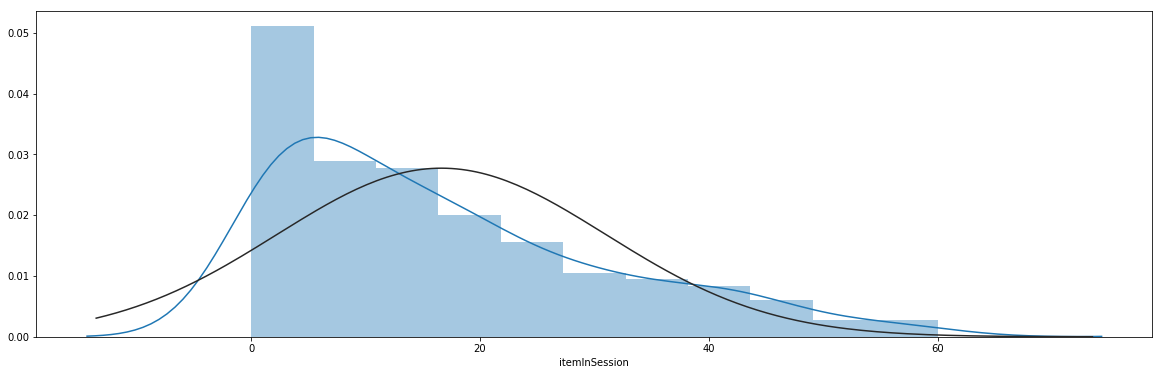

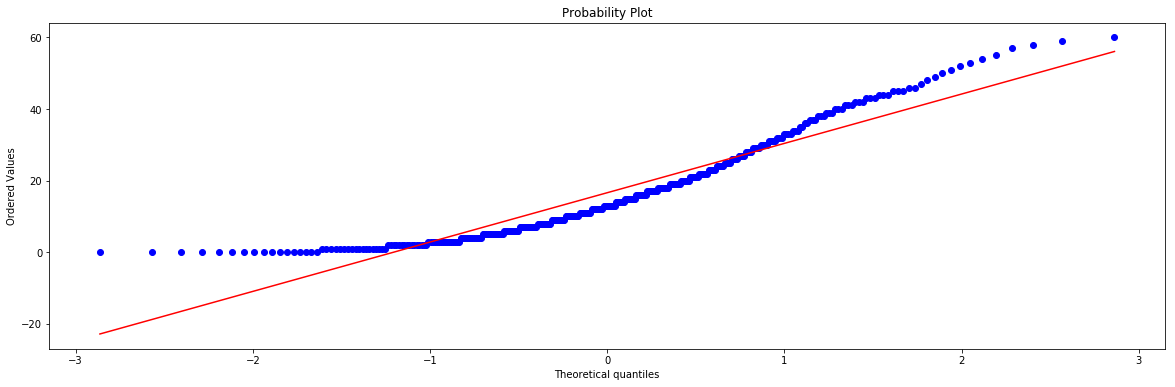

In [157]:
#histogram and normal probability plot
sns.distplot(df['itemInSession'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['itemInSession'], plot=plt)

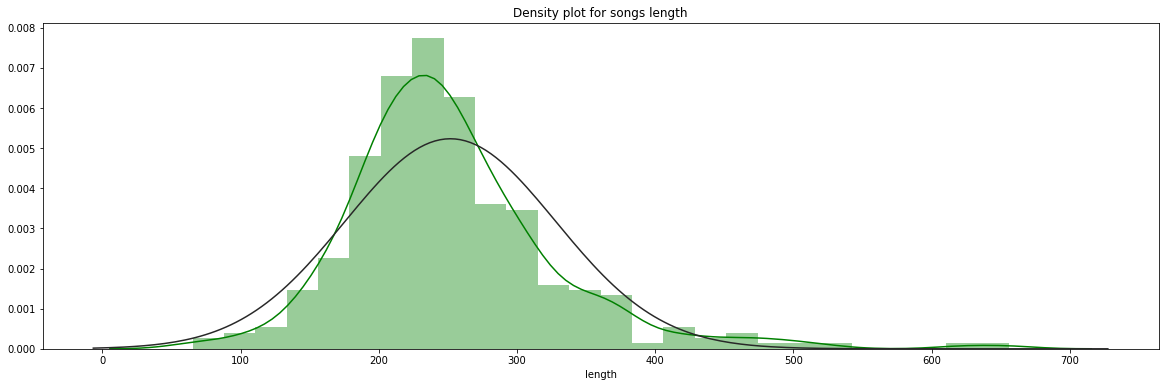

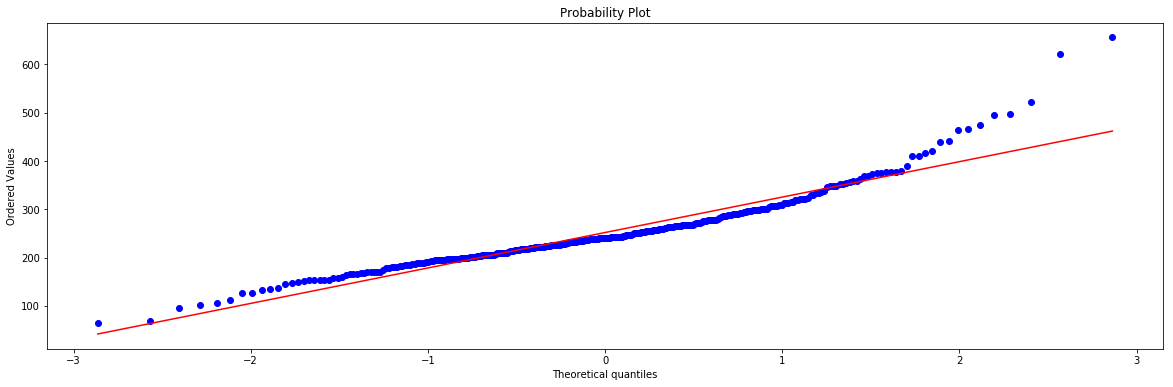

In [158]:
# Let's see the histogram and normal probability plot for the length of the songs
plt.title('Density plot for songs length')
sns.distplot(df['length'], fit=norm,color='green');
fig = plt.figure()
res = stats.probplot(df['length'], plot=plt)

In [159]:
# Let's get the unique records of UserId
songplay_data

[387,
 Timestamp('2018-11-30 19:54:24.796000'),
 '5',
 'free',
 None,
 None,
 985,
 'Detroit-Warren-Dearborn, MI',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"']

## Now let's make us questions...


#### And we are going to start with the question from the analytics team that is particularly interested in understanding what songs users are listening

In [160]:
# We go to the source table that is songplay_data
songplay_data

[387,
 Timestamp('2018-11-30 19:54:24.796000'),
 '5',
 'free',
 None,
 None,
 985,
 'Detroit-Warren-Dearborn, MI',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"']

In [161]:
# We only have one row that says that a user in 2018 used our app with free level from Michigan with a Macintosh
# The fields of the song and artists are null, so we cannot infere that info
# The good news is that the have a new Data Engineer in the team 
# and the analytics team will start performing much better from now on :)

In [162]:
# Let's continue!!
# Let's see how many songs we have in our database
# In our song table 
# There is only a song!
song_data

['SOMZWCG12A8C13C480', "I Didn't Mean To", 'ARD7TVE1187B99BFB1', 0, 218.93179]

# Let's check our df dataframe

In [163]:
df.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,state
0,Stephen Lynch,Logged In,Jayden,M,0,Bell,182.85669,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1.540992e+12,829,Jim Henson's Dead,200,2018-11-30 00:22:07.796,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,91,TX
1,Manowar,Logged In,Jacob,M,0,Klein,247.56200,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Shell Shock,200,2018-11-30 01:08:41.796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73,FL
2,Morcheeba,Logged In,Jacob,M,1,Klein,257.41016,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1.540558e+12,1049,Women Lose Weight (Feat: Slick Rick),200,2018-11-30 01:12:48.796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",73,FL


In [164]:
# Let's see some overview about our df information
df.describe()

,itemInSession,length,registration,sessionId,status
count,330.000000,330.000000,3.300000e+02,330.000000,330.0
mean,16.630303,251.803094,1.540887e+12,1050.260606,200.0
std,14.400998,76.354338,1.905504e+08,62.047280,0.0
min,0.000000,65.253420,1.540465e+12,618.000000,200.0
25%,5.000000,205.237100,1.540872e+12,1049.000000,200.0
50%,13.000000,240.495875,1.540941e+12,1076.000000,200.0
75%,25.000000,286.242813,1.541020e+12,1079.000000,200.0
max,60.000000,655.777510,1.541063e+12,1114.000000,200.0


##### From this information, we can see the:
##### 1. iteminSession varies from 0 to 60
##### 2. length varies from 65.25 to 655.77
##### 3. registration field varies from 1.540465e+12 to 1.541063e+12
##### 4. sessionId goes from 618.000000 to 1114.000000
##### 5. the status is always 200, that's good: we don't have crashes on this page, at least for this dataset

In [165]:
# It's good to know the numerical types in our dataset
list(set(df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')]

In [166]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,itemInSession,length,registration,sessionId,status
0,0,182.85669,1.540992e+12,829,200
1,0,247.56200,1.540558e+12,1049,200
2,1,257.41016,1.540558e+12,1049,200
3,2,231.23546,1.540558e+12,1049,200
4,3,216.76363,1.540558e+12,1049,200


## Let's continue with the questions

In [172]:
print('Unique songs on our dataset ',len(df.song.unique()))

Unique songs on our dataset  320


In [173]:
print('Unique artist on our dataset ',len(df.artist.unique()))

Unique artist on our dataset  292


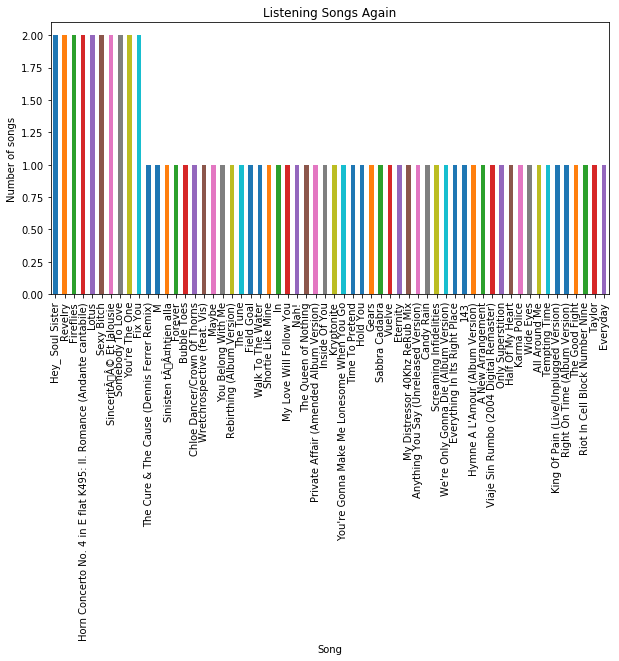

In [174]:
# Let's prepare an histogram of the data
df.song.value_counts().nlargest(60).plot(kind='bar', figsize=(10,5))
plt.title("Listening Songs Again")
plt.ylabel('Number of songs')
plt.xlabel('Song');

In [175]:
### Let's see something about the gender
### Is there more women or men listening our songs?
gender=user_df.groupby('gender').count()
gender

,userId,firstName,lastName,level
gender,,,,
F,181,181,181,181
M,149,149,149,149


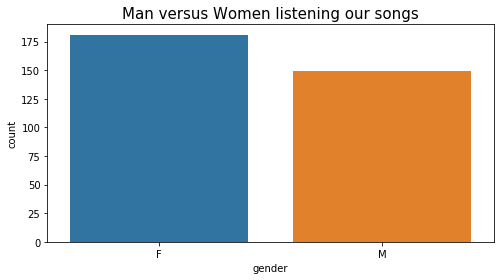

In [189]:
# Better to see the answer with Barplot
# There is more women listening our songs, that's interesting!
data = user_df
plt.figure(figsize=(8,4))
sns.countplot(data['gender'].sort_values())
plt.title("Man versus Women listening our songs",fontsize=15)
plt.show()

In [177]:
level=user_df.groupby('level').count()
level

,userId,firstName,lastName,gender
level,,,,
free,44,44,44,44
paid,286,286,286,286


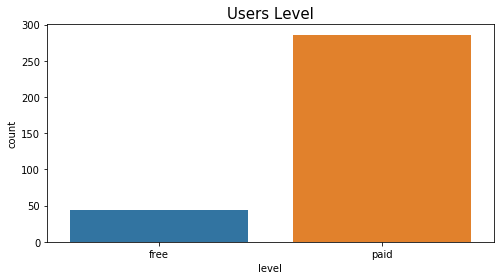

In [178]:
# Plot a Barplot
data = user_df
plt.figure(figsize=(8,4))
sns.countplot(data['level'].sort_values())
plt.title("Users Level",fontsize=15)
plt.show()

# What about location?

In [113]:
df['location'].head()

0        Dallas-Fort Worth-Arlington, TX
1    Tampa-St. Petersburg-Clearwater, FL
2    Tampa-St. Petersburg-Clearwater, FL
3    Tampa-St. Petersburg-Clearwater, FL
4    Tampa-St. Petersburg-Clearwater, FL
Name: location, dtype: object

In [114]:
# Prepare the data for a better visualization of the location column
# The location column has the form: Name,Short_Name, eg: 'Lexington-Fayette, KY'
# so we'll get the column location and split it by comma and then get the second part
# and then we'll take only the first part

df['state'] = df['location']
df['state'] = [i.split(",")[1] for i in df['state']]

#### Better having a column with the state

In [115]:
df['state'].head()

0     TX
1     FL
2     FL
3     FL
4     FL
Name: state, dtype: object

Text(0,0.5,'count')

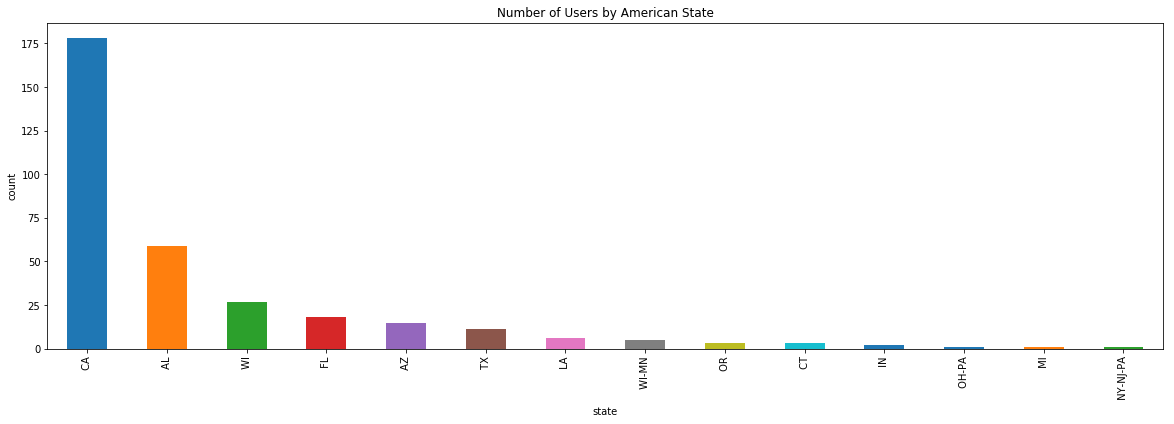

In [150]:
# Let's see where our most fans live
df.state.value_counts().plot(kind='bar')
plt.title('Number of Users by American State')
plt.xlabel('state')
plt.ylabel('count')

Run `test.ipynb` to see if you've successfully added records to this table.

# Close Connection to Sparkify Database

In [30]:
conn.close()

# Implement `etl.py`
Use what you've completed in this notebook to implement `etl.py`.